# 고객 생애가치 예측


## 1) 데이터 설명

- 이용 데이터 : Lpoint 데이터
- 2019년 7월 ~ 9월의 구매 데이터
- 총 6개의 비즈니스 유닛 (구매 채널) 
- 오프라인, 온라인 구매 채널이 3개씩 존재
- 온라인 채널의 경우 온라인 구매 행동 파악 가능, 오프라인의 경우 부재

## 2) 모델 설명

- target 변수 : 고객의 9월 구매 액수를 예측
    + y= log(9월 구매액+1)
- feature : 고객의 7,8 월 구매 관련 다양한 데이터
    + 구매 액수, 구매 제품 수, 거래 회수, 평균 거래 금액, 평균 거래 제품 수
    + 구매 제품의 다양성
    + 구매 액수간 편차


- 이용한 모델 : Deep Neural Network, optimizer = adam, metrics=mae, batch=512

## 3) 결과 설명 

- log transfer y 기준 mae 0.61 (Best)


## 4) 교훈 (Learning point) 

: Batch size, 이상치 제거, metrics, data normalization 에 따라서 결과의 quality 차이가 크다. 

- Batch size:  Batch 를 과도하게 크게 할시(설정하지 않을시) 모델이 동일한 y 로 예측하는 경우가 있었음
    + 이 경우에는 loss 는 낮았음
    + 전체의 평균, 혹은 최빈값 정도로 예측을 하여 mean error 만 줄이는 형태
- metrics: y 가 log error 로 이미 낮았기 때문에 (즉 0~1 사이의 값이 다수 존재하기때문에) squared 될 수록 loss 가 자연스럽게 작아져 learning 이 잘 되지 않았음

- 이상치 : 가격=0 등의 값을 제거하지 않을시 모델의 성능이 매우 낮았음. 특히 이상치 자체가 매우 높게 혹은 과도하게 낮게 예측되어 모델 전반의 performance 를 낮추는 결과 초래

In [674]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [675]:
path=os.getenv('HOME')+'/aiffel/kaggle/Lpoint/6th_Lpoint_competition'

In [676]:
trans_original=pd.read_csv(path+'/Transaction.csv', engine='python')
product=pd.read_csv(path+'/Products.csv', engine='python')


In [677]:
import pandas as pd 
import os
def get_trans_data():
    return trans_original[trans_original['clnt_id']==int(input('clnt_id'))]


# 1. Data 전처리

- Ecommerce transaction/behaviro log dataset

In [678]:
trans=trans_original

In [679]:
#날짜형 전처리
trans['de_dt']=trans['de_dt'].astype('str')
trans['de_tm']=trans['de_tm'].astype('str')
trans['de_tm']=pd.to_datetime(trans['de_dt'].str[0:4]+trans['de_dt'].str[4:7]+trans['de_dt'].str[7:]+"-"+trans['de_tm'])

In [680]:
def rename(data, origin, to):
    data.rename(columns={origin:to}, inplace=True)
    return data

In [681]:
#이상치 제거 (구매개수 =0 인 항목들)
# 데이터 칼럼 명 직관적으로 변경
trans=trans[trans['buy_am']>0]
trans.loc[trans['buy_ct']==0, 'buy_ct']=1

rename(trans, 'buy_am', 'total_price')
trans["itm_price"]=trans['total_price']/trans['buy_ct']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [682]:
#이상치 제거 전처리
#하루 구매 금액이 억대에 달하는 경우 : 제거
too_high_payer=trans.groupby('trans_id').sum()['total_price'].sort_values(ascending=False).head(5).index

too_low_payer=trans.groupby('trans_id').sum()['total_price'].sort_values().head(1000).index
# transcleaned=transcleaned[~trans['trans_id'].isin(too_low_payer)]
transcleaned=trans[~trans['trans_id'].isin([too_high_payer, too_low_payer])] #10원~100원 수준의 낮은 거래 고객 제거
trans=transcleaned

In [683]:
trans.drop_duplicates(inplace=True) #데이터 중복제거
transcleaned.describe()

,clnt_id,trans_id,trans_seq,total_price,buy_ct,itm_price
count,598690.000000,598690.000000,598690.000000,5.986900e+05,598690.000000,5.986900e+05
mean,36654.364364,77004.191969,5.705009,3.433730e+05,1.661723,2.168422e+05
std,20828.382051,46186.235951,5.372627,1.827737e+08,11.744266,1.332181e+08
min,2.000000,1.000000,1.000000,3.000000e+00,1.000000,8.333333e-01
25%,19153.000000,33266.250000,2.000000,1.990000e+03,1.000000,1.600000e+03
50%,36305.000000,78411.000000,4.000000,3.500000e+03,1.000000,3.000000e+03
75%,54841.750000,122034.750000,8.000000,6.980000e+03,1.000000,5.990000e+03
max,72424.000000,145849.000000,105.000000,1.000000e+11,3600.000000,1.000000e+11


In [684]:
trans_original.describe()

,clnt_id,trans_id,trans_seq,buy_am,buy_ct
count,599961.000000,599961.000000,599961.000000,5.999610e+05,599961.000000
mean,36654.874884,76984.159439,5.700024,3.426456e+05,1.649064
std,20825.948919,46154.902868,5.369946,1.825800e+08,11.732973
min,2.000000,1.000000,1.000000,0.000000e+00,0.000000
25%,19155.000000,33299.000000,2.000000,1.990000e+03,1.000000
50%,36308.000000,78373.000000,4.000000,3.500000e+03,1.000000
75%,54836.000000,121979.000000,8.000000,6.980000e+03,1.000000
max,72424.000000,145849.000000,105.000000,1.000000e+11,3600.000000


# 2. Feature extraction

In [685]:

def merge(a, b, how):
    x=pd.merge(a, b, how=how, left_on='clnt_id', right_on='clnt_id')
    return x


In [686]:
#각 거래 정보 기준으로 다양한 데이터 추출
jul=trans[trans['de_tm'].dt.month==7]
aug=trans[trans['de_tm'].dt.month==8]
sep=trans[trans['de_tm'].dt.month==9]


## 1) 거래 관련 기초 정보 : 액수,거래 건수, 물품 개수 관련

In [687]:
#월별 총 거래액, 총 물품 개수, 평균 거래액, 물품 개수, 거래 건수
#7월
sum_jul=pd.pivot_table(data=jul,index='clnt_id', values=['total_price', 'buy_ct'], aggfunc='sum', columns='biz_unit')
mean_jul=pd.pivot_table(data=jul,index='clnt_id', values=['total_price', 'buy_ct', ], aggfunc='mean', columns='biz_unit')
mean_jul.fillna(0, inplace=True)
count_jul=pd.pivot_table(data=jul,index='clnt_id', values='trans_id', aggfunc=pd.Series.nunique, columns='biz_unit')

rename(sum_jul, 'buy_ct', 'jul_itm_sum')
rename(sum_jul, 'total_price', 'jul_sum_price')
rename(mean_jul, 'buy_ct', 'jul_itm_mean')
rename(mean_jul, 'total_price', 'jul_mean_price')
rename(count_jul, 'trans_id', 'jul_trans_cnt')
jul_x=merge(merge(sum_jul, mean_jul, 'inner'), count_jul, 'inner')
#8월
sum_aug=pd.pivot_table(data=aug,index='clnt_id', values=['total_price', 'buy_ct'], aggfunc='sum', columns='biz_unit')
sum_aug.fillna(0, inplace=True)
mean_aug=pd.pivot_table(data=aug,index='clnt_id', values=['total_price', 'buy_ct', ], aggfunc='mean', columns='biz_unit')
mean_aug.fillna(0, inplace=True)
count_aug=pd.pivot_table(data=aug,index='clnt_id', values='trans_id', aggfunc=pd.Series.nunique, columns='biz_unit')
rename(sum_aug, 'buy_ct', 'aug_itm_sum')
rename(sum_aug, 'total_price', 'aug_sum_price')
rename(mean_aug, 'buy_ct', 'aug_itm_mean')
rename(mean_aug, 'total_price', 'aug_mean_price')
rename(count_aug, 'trans_id', 'aug_trans_cnt')
aug_x=merge(merge(sum_aug, mean_aug, 'inner'), count_aug, 'inner')

#9월에 대해서는 총 거래액수 (y) 만 포함하여 정보 유출 (information leakage) 방지 
data=merge(merge(aug_x, jul_x, 'inner'), sep.groupby('clnt_id').sum()['total_price'], "inner")
rename(data, 'total_price', 'sep_sum_price')
data.fillna(0, inplace=True)
data=data.reset_index()

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)


In [688]:
#7,8월의 거래액 총 합 추가
data=merge(data, trans[trans['de_tm'].dt.month.isin([7,8])].groupby('clnt_id').sum()['total_price'], 'inner')

In [689]:
rename(data, 'total_price', 'jul_aug_price')

,clnt_id,"(aug_itm_sum, A01)","(aug_itm_sum, A02)","(aug_itm_sum, A03)","(aug_itm_sum, B01)","(aug_itm_sum, B02)","(aug_itm_sum, B03)","(aug_sum_price, A01)","(aug_sum_price, A02)","(aug_sum_price, A03)",...,"(jul_mean_price, B02)","(jul_mean_price, B03)",A01_y,A02_y,A03_y,B01_y,B02_y,B03_y,sep_sum_price,jul_aug_price
0,9,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,1.0,2.0,0.0,0.0,235402,104539
1,20,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,102960.0,...,0.000000,0.0,0.0,0.0,2.0,1.0,0.0,0.0,100080,148290
2,23,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,2627.000000,0.0,1.0,0.0,0.0,0.0,3.0,0.0,145844,57120
3,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,72400,41030
4,29,0.0,0.0,10.0,0.0,11.0,0.0,0.0,0.0,42730.0,...,1504.285714,0.0,0.0,0.0,1.0,0.0,2.0,0.0,76450,110020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,72356,19.0,1.0,1.0,0.0,2.0,0.0,193500.0,27000.0,44900.0,...,0.000000,0.0,3.0,0.0,0.0,0.0,0.0,0.0,138176,332930
5946,72373,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,30690.0,...,0.000000,0.0,0.0,2.0,1.0,0.0,0.0,0.0,696160,342790
5947,72400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,148000.0,0.0,...,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,45810,256900
5948,72410,0.0,3.0,0.0,45.0,0.0,0.0,0.0,107220.0,0.0,...,0.000000,0.0,0.0,4.0,0.0,4.0,0.0,0.0,57900,414670


## 2) 각 거래마다의 deviation

(1) Standard deviation 이용

divide by zero encountered in log


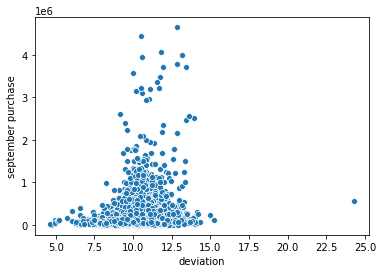

In [690]:
#각 거래마다의 deviation
jul_aug=trans[trans['de_tm'].dt.month.isin([7,8])]
df=jul_aug.groupby(["clnt_id","trans_id"]).sum()['total_price']
sf=pd.DataFrame(df)
ssf=sf.groupby('clnt_id').std()
tmp_data=merge(data, ssf, 'inner')
tmp=tmp_data[tmp_data['sep_sum_price']<5000000]
plt.figure()
sns.scatterplot(x=np.log(tmp['total_price']), y=tmp['sep_sum_price'])
plt.xlabel('deviation')
plt.ylabel('september purchase')
plt.show()

- 위의 그래프는 9월 거래액이 5,000,000 이하인 구매자의 분포이다. x 는 7,8월 거래에서의 표준편차, y는 9월 거래 총액 (y) 이다. 
- 해당 두 변수의 약한 수준의 양의 상관관계를 확인할 수 있다 (거래 건 마다의 거래액의 표준편차가 클수록 9월에 구매액이 높다)

In [691]:
data=merge(data, ssf,'inner')

In [692]:
rename(data, 'total_price', 'each_transaction_deviation')

,clnt_id,"(aug_itm_sum, A01)","(aug_itm_sum, A02)","(aug_itm_sum, A03)","(aug_itm_sum, B01)","(aug_itm_sum, B02)","(aug_itm_sum, B03)","(aug_sum_price, A01)","(aug_sum_price, A02)","(aug_sum_price, A03)",...,"(jul_mean_price, B03)",A01_y,A02_y,A03_y,B01_y,B02_y,B03_y,sep_sum_price,jul_aug_price,each_transaction_deviation
0,9,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,235402,104539,11935.891962
1,20,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,102960.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,100080,148290,21850.942085
2,23,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,145844,57120,9335.265395
3,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,72400,41030,25759.900039
4,29,0.0,0.0,10.0,0.0,11.0,0.0,0.0,0.0,42730.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,76450,110020,14932.261383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,72356,19.0,1.0,1.0,0.0,2.0,0.0,193500.0,27000.0,44900.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,138176,332930,15011.516853
5946,72373,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,30690.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,696160,342790,91384.993799
5947,72400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,148000.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,45810,256900,59287.463543
5948,72410,0.0,3.0,0.0,45.0,0.0,0.0,0.0,107220.0,0.0,...,0.0,0.0,4.0,0.0,4.0,0.0,0.0,57900,414670,21426.133865


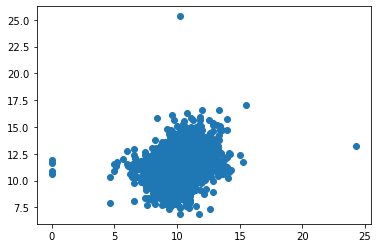

In [693]:
#단,50만원 이하의 구매고객이 아닌 전체 고객을 확인할 경우 구매액의 표준편차와 거래액 사이의 상관관계가 없다.
plt.scatter(x=np.log(data['each_transaction_deviation']+1), y=np.log(data['sep_sum_price']+1))

In [694]:
data['difference']=(data['sep_sum_price']-data['jul_aug_price'])/data['jul_aug_price']
data.sort_values(by='difference')

,clnt_id,"(aug_itm_sum, A01)","(aug_itm_sum, A02)","(aug_itm_sum, A03)","(aug_itm_sum, B01)","(aug_itm_sum, B02)","(aug_itm_sum, B03)","(aug_sum_price, A01)","(aug_sum_price, A02)","(aug_sum_price, A03)",...,A01_y,A02_y,A03_y,B01_y,B02_y,B03_y,sep_sum_price,jul_aug_price,each_transaction_deviation,difference
4126,50841,0.0,2.0,48.0,0.0,0.0,0.0,0.0,502000.0,1.000002e+11,...,0.0,0.0,0.0,3.0,0.0,0.0,573470,100000728362,3.535532e+10,-0.999994
1739,21456,0.0,1.0,0.0,223.0,0.0,0.0,0.0,427060.0,0.000000e+00,...,0.0,0.0,0.0,1.0,0.0,0.0,980,1841030,1.259420e+05,-0.999468
1597,19843,0.0,0.0,4.0,32.0,0.0,0.0,0.0,0.0,3.059000e+04,...,0.0,0.0,1.0,8.0,0.0,0.0,1000,525769,2.853853e+04,-0.998098
2029,25056,0.0,33.0,0.0,0.0,0.0,0.0,0.0,3518190.0,0.000000e+00,...,0.0,18.0,0.0,0.0,0.0,0.0,58680,23465390,2.396715e+05,-0.997499
5206,64012,0.0,26.0,0.0,0.0,0.0,0.0,0.0,2668400.0,0.000000e+00,...,0.0,3.0,0.0,0.0,0.0,0.0,7760,2948750,3.986977e+05,-0.997368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,49162,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11500.0,0.000000e+00,...,0.0,3.0,0.0,3.0,0.0,0.0,6134780,212980,1.701995e+04,27.804489
1173,14895,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,1.0,0.0,100390,3100,6.363961e+02,31.383871
1439,17859,0.0,1.0,0.0,3.0,0.0,0.0,0.0,49000.0,0.000000e+00,...,0.0,1.0,0.0,0.0,0.0,0.0,10023479,122870,1.420949e+04,80.577920
5782,70438,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,5.0,0.0,7707610,36510,4.302686e+03,210.109559


(2) 7월, 8월 총 거래 합 차이 이용

In [695]:
#7월과 8월의 거래 금액 차이
df=np.square(sum_aug['aug_sum_price']-sum_jul['jul_sum_price'])/(sum_aug['aug_sum_price']+sum_jul['jul_sum_price'])
df.rename_axis(None, axis=1, inplace=True)
df.fillna(0,inplace=True)

#merge
price_randomness=df['A01']+df['A02']+df['A03']+df['B01']+df['B02']+df['B03']
price_randomness=pd.DataFrame(price_randomness)
price_randomness.rename(columns={0:'price_randomness_square'}, inplace=True)
price_randomness=np.log(price_randomness+1)
data=merge(data, price_randomness, 'inner')


In [696]:
data['price_randomness_square']

0       10.848866
1       11.069229
2       10.684862
3       10.564396
4        8.011740
          ...    
5945    11.287527
5946    12.521616
5947     8.691481
5948     9.377260
5949    12.526390
Name: price_randomness_square, Length: 5950, dtype: float64

[[ 1.         -0.32599819]
 [-0.32599819  1.        ]]
0 13


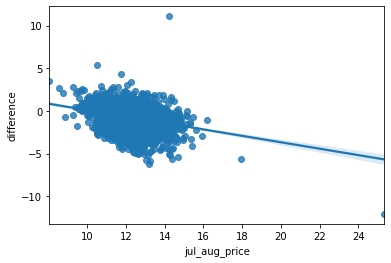

[[ 1.        -0.1776218]
 [-0.1776218  1.       ]]
13 100


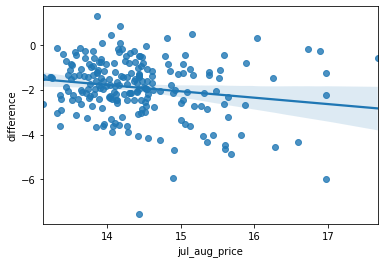

In [697]:
for n,m in [(0, 13), (13,100)]:
    x=np.log((data.loc[data['price_randomness_square'].between(n,m),'jul_aug_price']+1))
    y=np.log(data.loc[data['price_randomness_square'].between(n,m),'difference']+1)
    sns.regplot(x=x, y=y)
    print(np.corrcoef(x,y))
    print(n,m)
    plt.show()
#7,8월 구매 금액의 편차가 낮은 고객은 7,8월 구매 금액이 높을 수록 7,8-9월간의 구매 금액의 격차가 낮아졌다.
#7,8월 구매 금액의 편차가 높은 고객은 7,8월 구매 금액과 7,8-9월간의 구매 금액 격차가 뚜렷한 상관관계를 보이지 않았다.
#cluster 마다 변수간 다른 상관관계가 확인 됨 => Cross feature를 통해 집단간 변수의 interaction 이 잘 전달되도록 함

In [698]:
data['low_randomness']=0
data.loc[data['price_randomness_square']<13, 'low_randomness']=1
data['high_randomness']=0
data.loc[data['price_randomness_square']>=13, 'high_randomness']=1
data['ft_cross_aug_jul+low_rand']=data['low_randomness']*data['jul_aug_price']
data['ft_cross_aug_jul+high_rand']=data['high_randomness']*data['jul_aug_price']

## 3) Recency, Frequency : 고객의 활동성

In [699]:
trans['month']=trans['de_tm'].dt.month
trans['date']=trans['de_tm'].dt.date
trans

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,total_price,buy_ct,itm_price,month,date
0,21922,104999,1,A03,unknown,20190920,2019-09-20 12:41:00,5990,1,5990.0,9,2019-09-20
1,21279,104907,4,A03,unknown,20190920,2019-09-20 10:27:00,10900,1,10900.0,9,2019-09-20
2,39423,105124,11,A03,unknown,20190920,2019-09-20 17:26:00,12900,1,12900.0,9,2019-09-20
3,18362,104010,1,A03,unknown,20190920,2019-09-20 09:57:00,9900,1,9900.0,9,2019-09-20
4,39423,105124,13,A03,0565,20190920,2019-09-20 17:26:00,2990,1,2990.0,9,2019-09-20
...,...,...,...,...,...,...,...,...,...,...,...,...
599956,35311,2839,3,B03,0339,20190927,2019-09-27 14:09:00,3500,1,3500.0,9,2019-09-27
599957,35311,2839,4,B03,0339,20190927,2019-09-27 14:09:00,3600,2,1800.0,9,2019-09-27
599958,35311,2839,5,B03,0339,20190927,2019-09-27 14:09:00,3500,1,3500.0,9,2019-09-27
599959,35311,2839,2,B03,0339,20190927,2019-09-27 14:09:00,4500,1,4500.0,9,2019-09-27


In [700]:
#recency feature 추가

df1=trans[trans['month'].isin([7,8])]
df=df1.groupby('clnt_id').max()['date']

In [701]:
df=pd.DataFrame(df)

In [702]:
df['now']=pd.to_datetime("2019-08-30")
df['date']=pd.to_datetime(df['date'])
df['recency']=df['now']-df['date']
df['recency']=df['recency'].astype(int)
df
#frequencey : 거래 빈도 feature 추가
freq=pd.DataFrame((trans.groupby('clnt_id').max()['de_tm']-trans.groupby('clnt_id').min()['de_tm'])/trans.groupby('clnt_id').nunique()['trans_id'])
freq.columns=['freq']
freq=freq.astype(int)
freq
df1=pd.merge(df, freq, left_index=True, right_index=True)
df1['recency']=df1['recency']+1
df1['activeness']=df1['freq']/df1['recency']+1

#merge
df1[['recency', 'freq', 'activeness']]
data=merge(data, df1[['recency', 'freq', 'activeness']], "inner")

invalid value encountered in log
invalid value encountered in greater_equal
invalid value encountered in less_equal


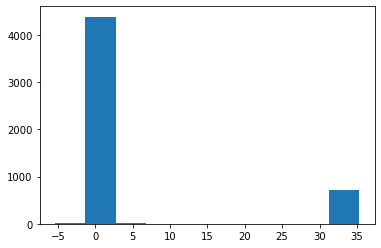

<AxesSubplot:xlabel='activeness', ylabel='sep_sum_price'>

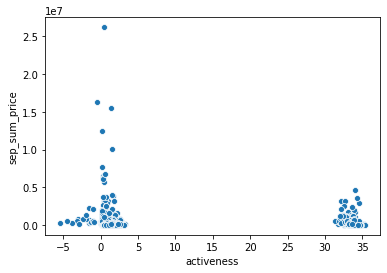

In [703]:
plt.hist(np.log(data['activeness']))
plt.show()
sns.scatterplot(x=np.log(data['activeness']), y=data['sep_sum_price'])
#고객의 활동성 activeness 지표 기준으로 9월 데이터를 plot 시 활동성을 기준으로 전체 집단이 극명하게 나뉘는 것을 볼 수 있다.
#이에 따라 활동성이 높은 그룹과 낮은 그룹을 나누는 feature 를 생성하여 기존 구매 액수와 cross feature 를 하면 예측에 도움이 될 것이라는 결론

In [704]:
data['active_group']=0
data['non_active_group']=0
data.loc[data['activeness']<8, 'non_active_group']=1
data.loc[data['activeness']>=8, 'active_group']=1

In [705]:
#activeness, randomness, jul_aug_price cross feature
data['cross_nonac_julaug_lowrand']=np.log(data['non_active_group']*data['jul_aug_price']*data['low_randomness']+1)
data['cross_nonac_julaug_highrand']=np.log(data['non_active_group']*data['jul_aug_price']*data['high_randomness']+1)
data['cross_ac_julaug_lowrand']=np.log(data['active_group']*data['jul_aug_price']*data['low_randomness']+1)
data['cross_ac_julaug_highrand']=np.log(data['active_group']*data['jul_aug_price']*data['high_randomness']+1)

divide by zero encountered in log


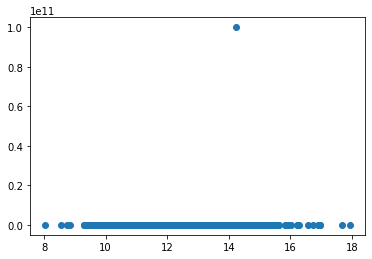

In [706]:
plt.scatter(x=np.log(data['non_active_group']*data['jul_aug_price']), y=data['sep_sum_price'])

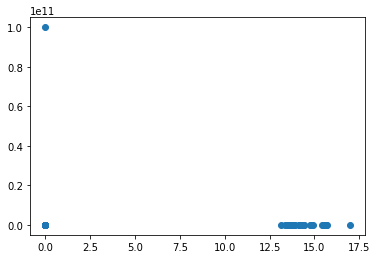

In [707]:
plt.scatter(x=np.log(data['active_group']*data['jul_aug_price']*data['high_randomness']+1), y=data['sep_sum_price'])

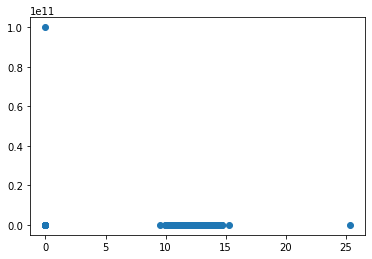

In [708]:
plt.scatter(x=np.log(data['active_group']*data['jul_aug_price']*data['low_randomness']+1), y=data['sep_sum_price'])

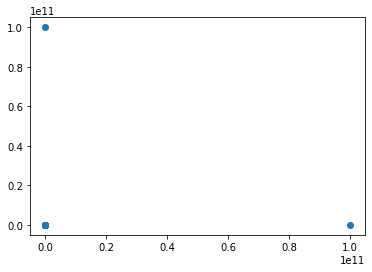

In [709]:
plt.scatter(x=data['active_group']*data['jul_aug_price'], y=data['sep_sum_price'])

In [710]:
#장바구니 내 제품 다양성  product_diversity_ratio : 장바구니 내 제품이 다양성이 다음월 구매 액수에 영향을 미칠 것이다.
trans.loc[trans['pd_c']=="unknown", 'pd_c']=0
df=trans[trans['month'].isin([7,8])].groupby(['clnt_id','pd_c']).sum()['buy_ct']/trans[trans['month'].isin([7,8])].groupby('clnt_id').sum()['buy_ct']
df1=np.square(df)
df2=df1.groupby('clnt_id').sum()
df2.columns=['product_diversity_ratio']
data=merge(data, np.log(df2), "inner")



In [711]:
#제품 다양성

train_trans=trans[trans['month'].isin([7,8])]
data=merge(data,np.log(train_trans.groupby('clnt_id').nunique()['pd_c']+1), 'inner')
rename(data, 'pd_c', 'product_div_count')
data.rename(columns={'buy_ct_y':'product_diversity_ratio'}, inplace=True)

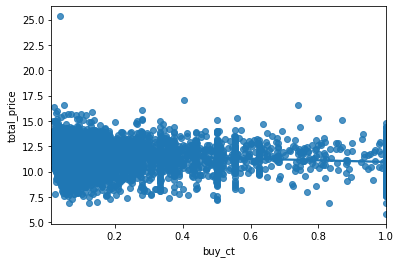

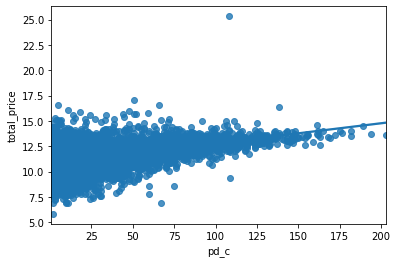

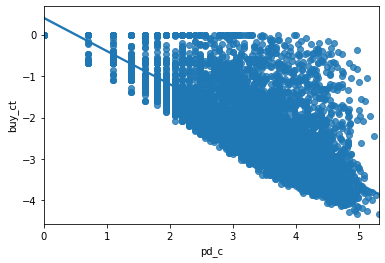

In [712]:
#시각화


#merge df2, not df3

df3=pd.merge(trans[trans['month']==9].groupby('clnt_id').sum()['total_price'], df2, left_index=True, right_index=True)
sns.regplot(x=df3.buy_ct, y=np.log(df3.total_price))
plt.show()
#buy_ct = product div ratio 

#제품 다양성이 높아질 수록 total price 의 표준 편차가 넓어짐
df3=pd.merge(df3,trans.groupby('clnt_id').nunique()['pd_c'], left_index=True, right_index=True)
#pd_c는 transaction 마다 제품 수

plt.show()
sns.regplot(x=df3['pd_c'], y=np.log(df3.total_price))
#총 구매한 제품의 종류가 많을 수록 9월의 구매량이 높다. 
plt.show()
sns.regplot(x=np.log(df3['pd_c']), y=np.log(df3.buy_ct))
plt.show()

# 2. Model

- 모델 : 
    +  Sequential deep learning : 첫째달, 둘째달 데이터를 넣어 세번째달 데이터를 예측하는 형태


- Feature (X data)  추출

Input data : 

- 첫째, 둘째달의 
    + [거래] : 총 거래액, 거래 빈도, 거래 물품 수, 거래의 규칙성(랜덤성 : 거래 가격의 갑작스러운 변화)
    + [제품] : 구매한 제품의 다양성
- 어떤 사람이 9월에 얼마나 살 확률이 높은지 예측
    + 누가 9월에 (재)구매할 확률이 높은지 -> 재구매 관련 데이터 입력
        - 채널별 고객 재구매 수준이 상이했음 -> 고객 구매 액수를 채널 별로 나눠서 인풋(거래 플랫폼)


In [713]:
data

,clnt_id,"(aug_itm_sum, A01)","(aug_itm_sum, A02)","(aug_itm_sum, A03)","(aug_itm_sum, B01)","(aug_itm_sum, B02)","(aug_itm_sum, B03)","(aug_sum_price, A01)","(aug_sum_price, A02)","(aug_sum_price, A03)",...,freq,activeness,active_group,non_active_group,cross_nonac_julaug_lowrand,cross_nonac_julaug_highrand,cross_ac_julaug_lowrand,cross_ac_julaug_highrand,buy_ct,product_div_count
0,9,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,840677142857142,2.621677e+00,0,1,11.557325,0.0,0.000000,0.0,-3.004031,3.091042
1,20,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,102960.0,...,1084054285714285,1.836462e+00,0,1,11.906932,0.0,0.000000,0.0,-2.164701,3.178054
2,23,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,799946666666666,3.314660e+00,0,1,10.952927,0.0,0.000000,0.0,-2.370590,2.639057
3,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1381640000000000,1.571114e+00,0,1,10.622083,0.0,0.000000,0.0,-2.230841,2.397895
4,29,0.0,0.0,10.0,0.0,11.0,0.0,0.0,0.0,42730.0,...,748493333333333,3.165779e+00,0,1,11.608427,0.0,0.000000,0.0,-2.612552,3.135494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,72356,19.0,1.0,1.0,0.0,2.0,0.0,193500.0,27000.0,44900.0,...,250955454545454,2.509555e+14,1,0,0.000000,0.0,12.715691,0.0,-2.134166,2.772589
5946,72373,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,30690.0,...,541920000000000,5.419200e+14,1,0,0.000000,0.0,12.744876,0.0,-2.187072,2.484907
5947,72400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,148000.0,0.0,...,847215000000000,2.961146e+00,0,1,12.456446,0.0,0.000000,0.0,-1.098612,1.386294
5948,72410,0.0,3.0,0.0,45.0,0.0,0.0,0.0,107220.0,0.0,...,423333750000000,4.233338e+14,1,0,0.000000,0.0,12.935241,0.0,-2.175040,3.496508


In [714]:
    
def show_result(model_name):
    def to_origin(data):
        return np.exp(data)-1

    yhat_test=to_origin(model_name.predict(X_test))
    Y_test_origin=to_origin(Y_test)
    result=pd.DataFrame({'prediction': yhat_test.flatten(), 'True_value':Y_test_origin})
    result['error']=np.abs(result['True_value']-result['prediction'])
    result
    print(result.describe())
    fig=plt.figure(figsize=(30,5))
    plt.hist(result['error'], bins=100)
    plt.show()


In [715]:
def model_compile(model_name, loss='mae', epoch=200, batch_size=512):
    model_name.compile(loss=loss,  metrics='mae', optimizer='adam')
    # fit the keras model on the dataset
    # Mae 로 LOSS 를 설정하지 않으면 모델이 제대로 업데이트 되지 않음

    history=model_name.fit(partial_x_train, partial_y_train, epochs=epoch, validation_data=(x_val, y_val),batch_size=batch_size, verbose=0)
    history_dict=history.history
    history_dict.keys()

    loss_values=history_dict['loss']
    val_loss_values=history_dict['val_loss']
    epochs=range(1, len(history_dict['val_loss'])+1)
    fig=plt.figure()
    plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')

    results = model_name.evaluate(X_test, Y_test)
    return results[0], history


In [716]:

import tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from numpy import loadtxt
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
# load the dataset
# split into input (X) and output (y) variables
# define the keras model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
data_X_raw=data.drop(['clnt_id', 'sep_sum_price', 'difference'],axis=1)
data_Y=np.log(data['sep_sum_price']+1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_X=pd.DataFrame(scaler.fit_transform(data_X_raw))
X_train, X_test, Y_train, Y_test=train_test_split(data_X, data_Y, test_size=0.2,random_state=0)

partial_x_train, x_val, partial_y_train, y_val=train_test_split(X_train, Y_train, test_size=0.2,random_state=0)


In [717]:
data_X

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.000000,0.000000,0.000000,0.001636,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.001452,...,0.322145,1.247379e-14,0.0,1.0,0.644512,0.0,0.000000,0.0,0.305911,0.556253
1,0.000000,0.000000,0.008013,0.000000,0.000000,0.0,0.000000,0.000000,1.029598e-06,0.000000,...,0.418645,1.211438e-14,0.0,1.0,0.664008,0.0,0.000000,0.0,0.499840,0.576438
2,0.000000,0.000000,0.000000,0.000000,0.001693,0.0,0.000000,0.000000,0.000000e+00,0.000000,...,0.305995,1.279098e-14,0.0,1.0,0.610806,0.0,0.000000,0.0,0.452269,0.451404
3,0.000000,0.000000,0.000000,0.000000,0.000564,0.0,0.000000,0.000000,0.000000e+00,0.000000,...,0.536639,1.199293e-14,0.0,1.0,0.592356,0.0,0.000000,0.0,0.484558,0.395460
4,0.000000,0.000000,0.003205,0.000000,0.006208,0.0,0.000000,0.000000,4.272993e-07,0.000000,...,0.285594,1.272283e-14,0.0,1.0,0.647361,0.0,0.000000,0.0,0.396363,0.566565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,0.463415,0.011765,0.000321,0.000000,0.001129,0.0,0.030220,0.001410,4.489993e-07,0.000000,...,0.088319,1.148664e-01,1.0,0.0,0.000000,0.0,0.502032,0.0,0.506895,0.482380
5946,0.000000,0.000000,0.001282,0.000000,0.000000,0.0,0.000000,0.000000,3.068995e-07,0.000000,...,0.203687,2.480456e-01,1.0,0.0,0.000000,0.0,0.503184,0.0,0.494671,0.415644
5947,0.000000,0.011765,0.000000,0.000000,0.000000,0.0,0.000000,0.007729,0.000000e+00,0.000000,...,0.324737,1.262917e-14,0.0,1.0,0.694652,0.0,0.000000,0.0,0.746163,0.160793
5948,0.000000,0.035294,0.000000,0.018405,0.000000,0.0,0.000000,0.005599,0.000000e+00,0.007816,...,0.156667,1.937667e-01,1.0,0.0,0.000000,0.0,0.510700,0.0,0.497451,0.650311


## 1) Big model

38/38 [==============================] - 0s 915us/step - loss: 0.6969 - mae: 0.6969


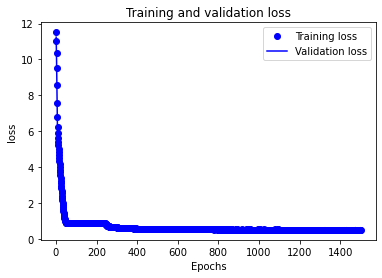

In [518]:
model1= keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_dim=len(data_X.columns)),
        layers.Dense(32,activation="relu"),
        layers.Dense(32,activation="tanh"),
        layers.Dense(16,activation="tanh"),
        layers.Dense(1,activation="linear"),
    ]
)

big_model_performance=model_compile(model1, epoch=1500)
#reg 없이 23000
#30대 부터 val_mae 0점대 진입
#데이터가 많아지니 확실히 hidden layer 가 줄어들어야함
#standard normalize 의 결과 : 동일한 5000 epoch 에서 더 낮은 test set loss


In [519]:
def to_origin(data):
    return np.exp(data)-1
yhat_test=to_origin(model1.predict(X_test))
Y_test_origin=to_origin(Y_test)
result_big_model=pd.DataFrame({'prediction': yhat_test.flatten(), 'True_value':Y_test_origin})
result_big_model['error']=np.abs(result_big_model['True_value']-result_big_model['prediction'])
result_big_model['error_rate']=result_big_model['True_value']/result_big_model['prediction']


In [520]:
result_big_model.describe()

,prediction,True_value,error,error_rate
count,1.190000e+03,1.190000e+03,1.190000e+03,1190.000000
mean,1.831974e+05,8.426502e+07,8.417128e+07,-435.742250
std,1.767967e+05,2.898900e+09,2.898883e+09,19904.381251
min,-9.846598e-02,1.000000e+03,4.167188e+01,-669977.596358
25%,7.782640e+04,5.887000e+04,2.484347e+04,0.577031
50%,1.310317e+05,1.315370e+05,5.590058e+04,0.941295
75%,2.293032e+05,2.399288e+05,1.156439e+05,1.501908
max,1.558107e+06,1.000018e+11,1.000011e+11,149730.422394


## 2) Model : Best model


38/38 [==============================] - 0s 830us/step - loss: 0.6737 - mae: 0.6737


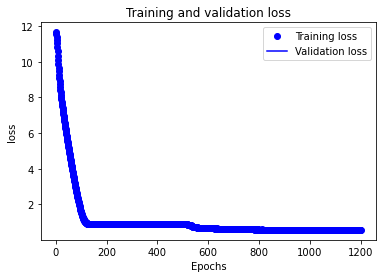

In [718]:
#big model 의 경우 모델의 사이즈가 커서 Overfitting 이 발생 
#모델 사이즈를 줄여서 best model 에 도달할 수 있었음
#local optima 를 극복하기 위해서 tanh 를 사용하였음
#Relu 만 사용할 때 보다 훨씬 속도가 빠름
model2 = keras.Sequential(
    [
        layers.Dense(4, activation="relu", input_dim=len(data_X.columns)),
        layers.Dense(8,activation="relu"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(1,activation="linear"),
    ]
)

small_model_performance=model_compile(model2, epoch=1200, loss='mae')

#데이터가 많아지니 확실히 hidden layer 가 줄어들어야함
#standard normalize 의 결과 : 동일한 5000 epoch 에서 더 낮은 test set loss 를 확인할 수 있었음
#데이터 전처리 진행하지 않을시 loss 가 0.05 이상 높았음

In [719]:
print(small_model_performance)
#최대 0.62 mae 의 성적 

(0.6736612319946289, <tensorflow.python.keras.callbacks.History object at 0x7f5e8410cf90>)


In [527]:
#이 모델로 실제 고객별로 예측해보았습니다.
yhat_test=to_origin(model2.predict(data_X))
Y_test_origin=to_origin(Y_test)

yhat_test=to_origin(model2.predict(X_test))
Y_test_origin=to_origin(Y_test)
result_small_model=pd.DataFrame({'prediction': yhat_test.flatten(), 'True_value':Y_test_origin})
result_small_model['error']=np.abs(result_small_model['True_value']-result_small_model['prediction'])
result_small_model['error_rate']=result_small_model['True_value']/result_small_model['prediction']


In [528]:
#각 고객에 대해서 예측한 값과 실제값 입니다.
#해당 결과를 시각화 시 실제 평균 오차 등을 확인 할 수 있습니다.
#Error rate 이란 실제값이 예측치 대비 얼마나 큰지 (몇배나 큰지, 실제값/예측값)임 
#실제 값보다 평균적으로 약 8만원 정도 낮게 예측했음을 알 수 있습니다.
result_small_model.describe()

,prediction,True_value,error,error_rate
count,1.190000e+03,1.190000e+03,1.190000e+03,1190.000000
mean,1.669108e+05,8.426502e+07,8.416805e+07,158.804076
std,1.407511e+05,2.898900e+09,2.898887e+09,5428.299083
min,1.593936e+03,1.000000e+03,3.185937e+01,0.005985
25%,7.836904e+04,5.887000e+04,2.286084e+04,0.598765
50%,1.236702e+05,1.315370e+05,5.095018e+04,0.988333
75%,2.064463e+05,2.399288e+05,1.103154e+05,1.576395
max,1.171755e+06,1.000018e+11,1.000012e+11,187258.075923


In [529]:
#각 고객별로 구매 가격에 따라서 Grouping 을 진행하였습니다.
#Grouping 진행시 실제 정확한 그룹에 들어갔는지 확인 하여 model 의 accuracy 를 볼 수 있었습니다.
result_small_model.loc[result_small_model['prediction']<100000, 'predicted_level']=0
result_small_model.loc[result_small_model['prediction']>=100000, 'predicted_level']=1
result_small_model.loc[result_small_model['prediction']>=250000, 'predicted_level']=2
result_small_model.loc[result_small_model['prediction']>=500000, 'predicted_level']=3
result_small_model.loc[result_small_model['prediction']>=800000, 'predicted_level']=4
result_small_model.loc[result_small_model['prediction']>=1500000, 'predicted_level']=5



In [530]:
result_small_model.loc[result_small_model['True_value']<100000, 'real_level']=0
result_small_model.loc[result_small_model['True_value']>=100000, 'real_level']=1
result_small_model.loc[result_small_model['True_value']>=250000, 'real_level']=2
result_small_model.loc[result_small_model['True_value']>=500000, 'real_level']=3
result_small_model.loc[result_small_model['True_value']>=800000, 'real_level']=4
result_small_model.loc[result_small_model['True_value']>=1500000, 'real_level']=5


In [531]:
result_small_model

,prediction,True_value,error,error_rate,predicted_level,real_level
134,207502.750000,131580.0,75922.750000,0.634112,1.0,1.0
1364,336307.187500,856400.0,520092.812500,2.546481,2.0,4.0
555,132420.468750,116192.0,16228.468750,0.877447,1.0,1.0
4447,88966.859375,27040.0,61926.859375,0.303933,0.0,0.0
2858,136300.453125,43950.0,92350.453125,0.322449,1.0,0.0
...,...,...,...,...,...,...
666,87163.562500,11900.0,75263.562500,0.136525,0.0,0.0
1547,177376.031250,341515.0,164138.968750,1.925373,1.0,2.0
2857,454637.968750,80295.0,374342.968750,0.176613,2.0,0.0
3955,238762.828125,537260.0,298497.171875,2.250183,1.0,3.0


In [532]:
result_small_model['correct']=0
result_small_model.loc[result_small_model['predicted_level']==result_small_model['real_level'], 'correct']=1

In [533]:
result_small_model.describe()

,prediction,True_value,error,error_rate,predicted_level,real_level,correct
count,1.190000e+03,1.190000e+03,1.190000e+03,1190.000000,1190.000000,1190.000000,1190.000000
mean,1.669108e+05,8.426502e+07,8.416805e+07,158.804076,0.833613,0.947899,0.572269
std,1.407511e+05,2.898900e+09,2.898887e+09,5428.299083,0.830989,1.044337,0.494958
min,1.593936e+03,1.000000e+03,3.185937e+01,0.005985,0.000000,0.000000,0.000000
25%,7.836904e+04,5.887000e+04,2.286084e+04,0.598765,0.000000,0.000000,0.000000
50%,1.236702e+05,1.315370e+05,5.095018e+04,0.988333,1.000000,1.000000,1.000000
75%,2.064463e+05,2.399288e+05,1.103154e+05,1.576395,1.000000,1.000000,1.000000
max,1.171755e+06,1.000018e+11,1.000012e+11,187258.075923,4.000000,5.000000,1.000000


## 3) difference learning 

In [397]:
#7,8월과 9월 구매 가격의 높은 correlation 에 착안하여, feature 를 9월-(7,8월 구매액) 에 대해서 learning 시켰다.
#결과적으로 성능은 훨씬 낮았다. 
data_X=data.drop(['clnt_id', 'sep_sum_price', 'difference'],axis=1)
data_Y=np.log(data['difference']+1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_X=pd.DataFrame(scaler.fit_transform(data_X))
X_train, X_test, Y_train, Y_test=train_test_split(data_X, data_Y, test_size=0.2,random_state=0)

partial_x_train, x_val, partial_y_train, y_val=train_test_split(X_train, Y_train, test_size=0.2,random_state=0)

38/38 [==============================] - 0s 800us/step - loss: 0.7046 - mae: 0.7046


(0.7045944929122925,
 <tensorflow.python.keras.callbacks.History at 0x7f606bb51e50>)

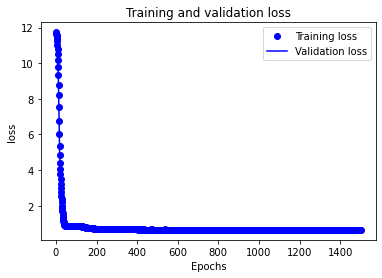

In [590]:
model_difference = keras.Sequential(
    [
        layers.Dense(4, activation="relu", input_dim=len(data_X.columns)),
        layers.Dense(8,activation="relu"),
        layers.Dense(16,activation="tanh"),
        layers.Dense(1,activation="linear"),
    ]
)

model_compile(model_difference, epoch=1500)


In [535]:
yhat_test=to_origin(model_difference.predict(X_test))
Y_test_origin=to_origin(Y_test)
jul_aug_price=data.loc[data.index.isin(Y_test.index), 'jul_aug_price']
result3=pd.DataFrame({'difference_prediction': yhat_test.flatten(), 'True_difference_value':Y_test_origin, 'jul_aug_price':jul_aug_price})

result3['september_purchase']=data.loc[data.index.isin(Y_test.index), 'sep_sum_price']

result3['puchase_predict']=result3['jul_aug_price']*(result3['difference_prediction']+1)
result3['error']=np.abs(result3['puchase_predict']-result3['september_purchase'])
result3['error_rate']=result3['september_purchase']/result3['puchase_predict']

In [536]:
result3

,difference_prediction,True_difference_value,jul_aug_price,september_purchase,puchase_predict,error,error_rate
1,142131.687500,100080.0,148290,100080,2.107686e+10,2.107676e+10,4.748336e-06
4,247943.562500,76450.0,110020,76450,2.727886e+10,2.727878e+10,2.802536e-06
12,177703.828125,62960.0,132775,62960,2.359476e+10,2.359470e+10,2.668389e-06
14,134618.093750,172912.0,611783,172912,8.235767e+10,8.235750e+10,2.099525e-06
15,130465.835938,152500.0,453696,152500,5.919228e+10,5.919213e+10,2.576349e-06
...,...,...,...,...,...,...,...
5918,78828.273438,30400.0,334682,30400,2.638274e+10,2.638271e+10,1.152269e-06
5925,187350.046875,1319376.0,793160,1319376,1.485994e+11,1.485980e+11,8.878746e-06
5929,254499.406250,258230.0,917038,258230,2.333865e+11,2.333863e+11,1.106448e-06
5940,323787.625000,1024280.0,461950,1024280,1.495742e+11,1.495731e+11,6.847974e-06


In [538]:
result3.describe()
#error 의 평균 (실제 값-예측값의 mean average error ) 가 best model 에 비해 높음 =
#성능이 높지 않음

,difference_prediction,True_difference_value,jul_aug_price,september_purchase,puchase_predict,error,error_rate
count,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03
mean,1.656410e+05,8.426502e+07,4.861057e+05,8.426502e+07,7.940138e+10,7.931712e+10,4.258924e-04
std,1.373831e+05,2.898900e+09,1.061013e+06,2.898900e+09,1.996547e+11,1.996244e+11,1.444394e-02
min,6.455147e+03,1.000000e+03,1.070000e+04,1.000000e+03,7.045433e+08,7.044406e+08,1.060814e-08
25%,7.490641e+04,5.887000e+04,1.656632e+05,5.887000e+04,1.834447e+10,1.834441e+10,1.475772e-06
50%,1.250647e+05,1.315370e+05,2.999135e+05,1.315370e+05,3.636379e+10,3.636370e+10,3.354140e-06
75%,2.142710e+05,2.399288e+05,5.354625e+05,2.399288e+05,8.482181e+10,8.482161e+10,6.941854e-06
max,1.629149e+06,1.000018e+11,2.346539e+07,1.000018e+11,4.694508e+12,4.694508e+12,4.982697e-01


## 4) Randomforest regressor

In [539]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
rf = RandomForestRegressor(max_depth=200, random_state=0)
rf.fit(X_train, Y_train)
y_pred=rf.predict(X_test)
rf_model_performance=mean_absolute_error(Y_test, y_pred)

In [540]:
yhat_test=to_origin(rf.predict(X_test))
Y_test_origin=to_origin(Y_test)
result_rf=pd.DataFrame({'prediction': yhat_test.flatten(), 'True_value':Y_test_origin})
result_rf['error']=np.abs(result_rf['True_value']-result_rf['prediction'])
result_rf['error_rate']=result_rf['True_value']/result_rf['prediction']
result_rf


,prediction,True_value,error,error_rate
134,293571.171771,131580.0,161991.171771,0.448205
1364,260123.020027,856400.0,596276.979973,3.292288
555,151062.618599,116192.0,34870.618599,0.769164
4447,134265.639080,27040.0,107225.639080,0.201392
2858,92877.671108,43950.0,48927.671108,0.473203
...,...,...,...,...
666,99635.261114,11900.0,87735.261114,0.119436
1547,162651.488522,341515.0,178863.511478,2.099673
2857,387822.226147,80295.0,307527.226147,0.207041
3955,128374.485920,537260.0,408885.514080,4.185100


In [541]:
result_rf.describe()
#Mean error 가 8e+07 로 best model 대비 100배 가량 높음 

,prediction,True_value,error,error_rate
count,1.190000e+03,1.190000e+03,1.190000e+03,1190.000000
mean,1.526825e+05,8.426502e+07,8.417114e+07,117.893501
std,1.261727e+05,2.898900e+09,2.898881e+09,4012.916380
min,1.031415e+04,1.000000e+03,1.756702e+02,0.005682
25%,7.608444e+04,5.887000e+04,2.280893e+04,0.647326
50%,1.173278e+05,1.315370e+05,5.320188e+04,1.036233
75%,1.944811e+05,2.399288e+05,1.116363e+05,1.652895
max,1.685640e+06,1.000018e+11,1.000010e+11,138432.611649


## 5) Classification modeling

In [477]:
#Regression 이 아닌 classification 으로 진행
#총 6개 클래스 모델링
#총 test accuracy 가 0.4 를 넘지 못함
# 차라리 regression 을 한 뒤 각 prediction 에 대해서 구간 별 level을 부여하는 방법이 더 정확도가 높음

import tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from numpy import loadtxt
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
# load the dataset
# split into input (X) and output (y) variables
# define the keras model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
data.dropna(inplace=True)

for i,v in enumerate([0, 50000,100000,160000,250000, 500000]):
    data.loc[data['sep_sum_price']>v, 'True_class']=i

data_X=data.drop(['clnt_id', 'sep_sum_price', 'difference','True_class'],axis=1)
data_Y=data['True_class']
data.groupby('True_class').size()


True_class
0.0    1119
1.0    1170
2.0    1068
3.0    1015
4.0    1081
5.0     497
dtype: int64

In [478]:
data.groupby('True_class').size()

True_class
0.0    1119
1.0    1170
2.0    1068
3.0    1015
4.0    1081
5.0     497
dtype: int64

In [479]:
# Categorical Encoding of the Labels
def to_one_hot(labels, dimension=6):
    results = np.zeros((len(labels), dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results
data_Y=data_Y.astype(int)
data_Y_onehot = to_one_hot(data_Y)

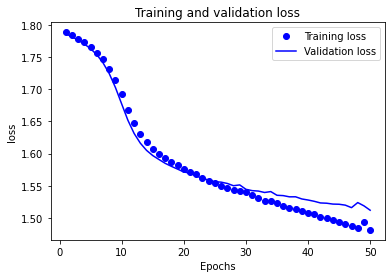

38/38 [==============================] - 0s 825us/step - loss: 1.5193 - accuracy: 0.3437
[1.519294261932373, 0.3436974883079529]


In [544]:
def model_compile(model_name, loss, optimizer,epoch=200, batch_size=512, metrics='accuracy'):
    model_name.compile(loss=loss,metrics=metrics,  optimizer=optimizer)
    # fit the keras model on the dataset
    # Mae 로 LOSS 를 설정하지 않으면 모델이 제대로 업데이트 되지 않음

    history=model_name.fit(partial_x_train, partial_y_train, epochs=epoch, validation_data=(x_val, y_val),batch_size=batch_size, verbose=0)
    history_dict=history.history
    history_dict.keys()

    import matplotlib.pyplot as plt
    loss_values=history_dict['loss']
    val_loss_values=history_dict['val_loss']
    epochs=range(1, len(history_dict['val_loss'])+1)


    plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()
    results = model_name.evaluate(X_test, Y_test)
    print(results)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_X)
data_X_scale=scaler.transform(data_X)

X_train, X_test, Y_train, Y_test=train_test_split(data_X_scale, data_Y_onehot, test_size=0.2,random_state=0)

partial_x_train, x_val, partial_y_train, y_val=train_test_split(X_train, Y_train, test_size=0.2,random_state=0)



model5 = keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_dim=len(data_X.columns)),
        layers.Dense(32,activation="relu"),
        layers.Dense(32,activation="tanh"),
        layers.Dense(16,activation="relu"),
        layers.Dense(6,activation="sigmoid"),
    ]
)
model_compile(model5, loss='categorical_crossentropy',metrics='accuracy', epoch=50, batch_size=512, optimizer='adam')


# 3. Best model analysis

## 1) Model 

### (1) Model structure

- 1.변수가 추가될 수록 모델은 가벼워질때 높은 성능을 나타냈다. 
- 2. 전처리, 이상치를 제거할 시 성능이 점차 높아짐을 확인할 수 있었다
    + (특히 과도하게 높은 구매금액, 이상치 : 구매금액 0 등)
- 3. Relu 를 이용시 Local optima 에서 빠져나오지 못하는 모습 확인 : Tanh 를 이용해 학습 속도를 높일 수 있었다.

In [545]:
model2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 4)                 316       
_________________________________________________________________
dense_153 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_154 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_155 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 9         
Total params: 509
Trainable params: 509
Non-trainable params: 0
_________________________________________________________________


### (2) Learning Curve

- 총 4단계로 나눠볼 수 있었음
- 1단계 : 급격한 loss 감소
- 2단계 : Saddle point
- 3단계 : Saddle point 극복
- 4단계 : Overfitting 시작

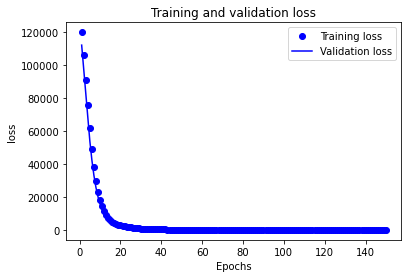

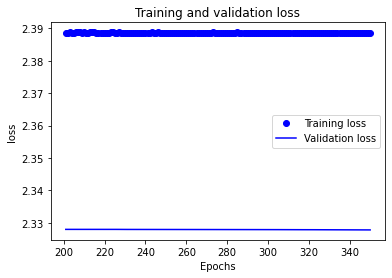

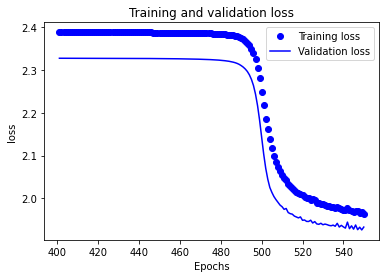

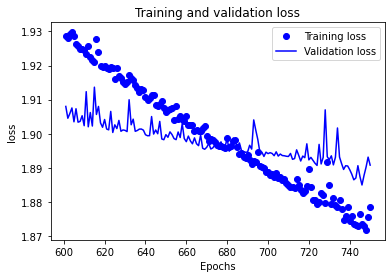

In [563]:
start=[0,200,400,600]
for from_epoch in start:
    history=small_model_performance[1]
    history_dict=history.history
    loss_values=np.exp(history_dict['loss'][from_epoch:from_epoch+150])
    val_loss_values=np.exp(history_dict['val_loss'][from_epoch:from_epoch+150])
    epochs=range(1+from_epoch, from_epoch+151)
    
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()


## 2) 고객 행동 예측에 관한 설명

### (1) 모델의 행동 예측 성과

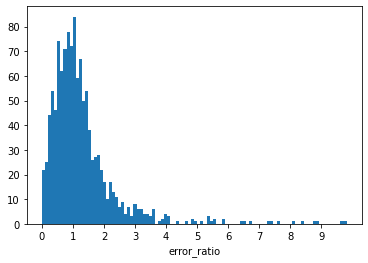

In [413]:
#약 50% 의 고객이 실제 가격에 65~150% 로 예측할 수 있었다. 
#그 외에 갑작스러운 행동 : 갑자기 구매를 적게 함, 갑작스럽게 많은 구매를 하는 것 등으로 예측이 어려웠다. 
#더욱 디테일한 예측을 위해서는 상세한 행동 패턴을 확인할 수 있는 앱데이터, 개인적인 정보(성별, 연령, 가입일 등) 이 필요하다.
plt.hist(result_small_model.loc[result_small_model['error_rate']<10, 'error_rate'], bins=100)
plt.xticks(ticks=range(0,10))
plt.xlabel('error_ratio')
plt.show()

In [424]:
result_small_model['error_rate'].describe()

count    1190.000000
mean        1.856149
std        14.464221
min         0.009189
25%         0.652982
50%         1.046255
75%         1.550645
max       496.458338
Name: error_rate, dtype: float64

### (2) 실제 과소/과대 평가된 고객 행동 예시 : 

특히 고객 중 갑작스러운 행동 변화가 있는 경우 가장 예측하기 어려웠다.

In [425]:

#과소 평가된 고객은 누구였을까?
overpredicted_client=data.loc[data_X.index.isin(result_small_model[result_small_model['error_rate']> 10].index), "clnt_id"].values
overpredicted_trans=trans[trans['clnt_id'].isin(overpredicted_client)]
overpredicted_trans.groupby('clnt_id').sum()['total_price']
#총 구매 금액 백만원 대 고객

clnt_id
3473      8342643
9678     34024070
17422      577064
17664    10028550
23902     2868390
25934       77440
33024      672635
38003      918592
43136      424985
45814      152760
47702      632938
54030      540332
57350      886888
71623      329178
71903      526571
72254     1547110
Name: total_price, dtype: int64

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


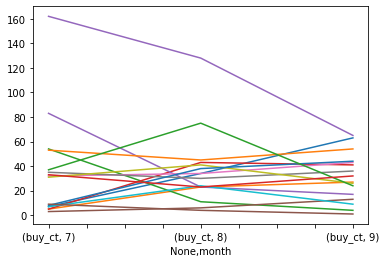

In [456]:
#이들을 왜 잘못 예측했을까 ?

# 가설 1. 이들이 갑작스럽게 9월에 다른 행동을 했다. 
overpredicted_client=data.loc[data_X.index.isin(result_small_model[result_small_model['error_rate']> 10].index), "clnt_id"].values
overpredicted_trans=trans[trans['clnt_id'].isin(overpredicted_client)]
overpredicted_trans.groupby('clnt_id').sum()['total_price']
df=pd.pivot_table(overpredicted_trans[['clnt_id','buy_ct', 'month','biz_unit']], columns=['month'], index='clnt_id', aggfunc='sum')
df=df.T
fig=df.plot()
fig.get_legend().remove()
#1) 구매 개수의 변화 :
#실제로 7,8,9 월의 구매 개수를 볼 때 160 -> 120 -> 60 등 격하게 떨어지고 있음을 확인 할 수 있다. 
#고객의 세세한 패턴 변화까지 예측할 수 있는 모델이 필요하다.

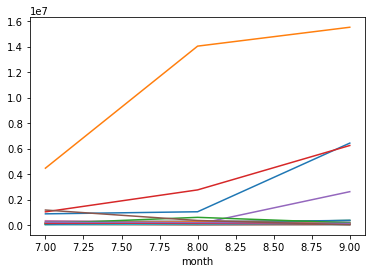

In [457]:
#2) 구매 가격의 변화 : 구매 가격이 급증한 고객들 또한 잡아내지 못함
overpredicted_client=data.loc[data_X.index.isin(result_small_model[result_small_model['error_rate']> 10].index), "clnt_id"].values
overpredicted_trans=trans[trans['clnt_id'].isin(overpredicted_client)]
overpredicted_trans.groupby('clnt_id').sum()['total_price']
df=pd.pivot_table(overpredicted_trans, columns='month', index='clnt_id', aggfunc='sum')['total_price']
df=df.T
fig=df.plot()
fig.get_legend().remove()

## 3) Feature importance

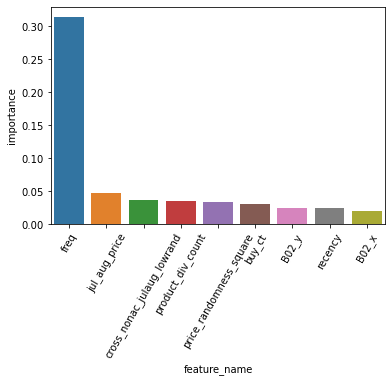

In [783]:
#구매 빈도, 7,8월 총 구매 금액, non active group의 7,8월 구매 금액 (cross feature), 거래금액의 랜덤성, 고객 거래의 recency가 중요
values=rf.feature_importances_
indexes=list(data_X_raw.columns)
feat_importance=pd.DataFrame({'feature_name':indexes, 'importance':values})
top=feat_importance.sort_values(by='importance', ascending=False).head(9)
sns.barplot(x=top['feature_name'], y=top['importance'])
plt.xticks(rotation=60)
plt.show()

<AxesSubplot:>

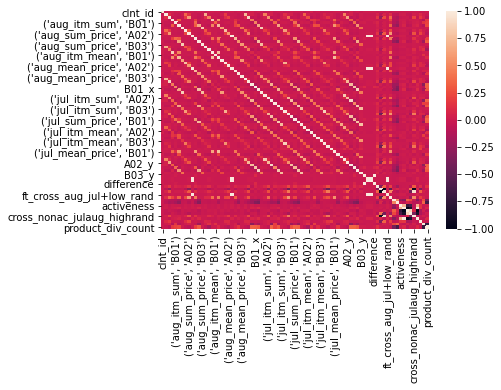

In [789]:
sns.heatmap(data.corr())

In [795]:
#각 채널에서의 거래량, 각 채널에서의 거래빈도수, 총 거래 빈도수가 9월 구매액과 깊은 연관 있음
# (difference 는 feature가 아님)
np.abs(data.corr()['sep_sum_price']).sort_values(ascending=False).head(10)

sep_sum_price           1.000000
difference              0.999994
B01_x                   0.093957
B01_y                   0.072678
(jul_sum_price, B01)    0.048466
(aug_sum_price, B01)    0.039723
(aug_itm_sum, B01)      0.026879
(jul_itm_sum, B01)      0.019801
freq                    0.017062
product_div_count       0.017050
Name: sep_sum_price, dtype: float64